In [1]:
import numpy as np
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import pandas as pd
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from matplotlib.colors import ListedColormap
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
sns.set_style('darkgrid')

In [2]:
from clustering_utils import umap,tSNE,compute_most_represented_class_per_cluster,substitute_classes_labels
from cVAE_architecture2 import cVAE2, loss_vae
from cVAE_train_utils2 import train_cVAE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 128
cmap = plt.cm.get_cmap('viridis', 10)


In [3]:
from sklearn.manifold import TSNE
def tSNE(z, latent_space, clustering_labels, true_labels=None, cmap='viridis', aff_true_labels=True,data=None):
    # t-SNE projection
    tSNE_2d = TSNE(n_components=2) 
    proj_2d = tSNE_2d.fit_transform(z)  
    
    params = {'backend': 'Agg', "font.family": "calibri"}  # extend as needed
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"] = 1.25
    fig = plt.figure()
    fig, ax = plt.subplots(layout="constrained")
    scatter = ax.scatter(x=proj_2d[:, 0], y=proj_2d[:, 1], s=10, c=clustering_labels, alpha=0.9, cmap=cmap)
    legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes", fontsize=5)
    
    ax.set_facecolor("white")
    ax.add_artist(legend1)
    plt.title(f'Prediction (Number of clusters ={latent_space})', fontsize=20)
    plt.xlabel('tSNE_1', fontsize=24)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('tSNE_2', fontsize=24)
    plt.savefig('./Results/tSNE_prediction_Zdim'+str(latent_space)+str(data)+'.png')
    plt.show()

    # Display the true labels if aff_true_labels is True
    if aff_true_labels:
        fig, ax = plt.subplots(layout="constrained")
        
        scatter = ax.scatter(x=proj_2d[:, 0], y=proj_2d[:, 1], s=10, c=true_labels, alpha=0.9, cmap="winter")
        legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes", fontsize=5)
        
        ax.set_facecolor("white")
        ax.add_artist(legend1)
        plt.title(f'Mutations' , fontsize=20)
        plt.xlabel('tSNE_1', fontsize=24)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.ylabel('tSNE_2', fontsize=24)
        plt.savefig('./Results/tSNE_gt_Zdim'+str(latent_space)+str(data)+'.png')
        plt.show()
    return proj_2d
        
        

In [4]:
def pourcentage_label(label,l,y):
    count_0 = 0
    count_1 = 0
    for i in range (len(y)):
        if l[i]==label and y[i]==0:
            count_0+=1
        if l[i]==label and y[i]==1:
            count_1+=1
    
    count_0 = (count_0*100)/(np.sum(l==label))
    count_1 = (count_1*100)/(np.sum(l==label))
    print(f"For label {label}:")
    print(f"number of cells of the cluster: {np.sum(l==label)}")
    print(f"Percentage of occurrences of wild cells: {count_0:.2f}%")
    print(f"Percentage of occurrences of mutation cells: {count_1:.2f}%")
    return count_0,count_1,np.sum(l==label)         

def pourcentage_cells(labels,y):
    print("")
    print("number of cells Wild = ",np.sum(y==0))
    print("number of Mutation cells  = ",np.sum(y==1))
    for label in set(labels):
        pourcentage_label(label,labels,y)

## Wild vs PIK3CA

In [5]:
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((192, 192)),
                                transforms.ToTensor()])

dataset = datasets.ImageFolder(root='../cropped_cells_original_rotated_balanced', transform=transform)

train_proportion = 0.8
test_proportion = 1 - train_proportion

# Calculate the number of samples for each split
total_samples = len(dataset)
train_samples = int(train_proportion * total_samples)
test_samples = total_samples - train_samples

# Use random_split to create train and test datasets with the calculated proportions
train_dataset, test_dataset = random_split(dataset, [train_samples, test_samples])

# Create DataLoader instances to load batches during training and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train = []
Y_train = []
for images, labels in train_loader:
    X_train.append(images)
    Y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
Y_train = torch.cat(Y_train, dim=0)

X_test = []
Y_test = []
for images, labels in test_loader:
    X_test.append(images)
    Y_test.append(labels)
X_test = torch.cat(X_test, dim=0)
Y_test = torch.cat(Y_test, dim=0)

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: torch.Size([4026, 1, 192, 192])
Y_train shape: torch.Size([4026])
X_test shape: torch.Size([1007, 1, 192, 192])
Y_test shape: torch.Size([1007])


In [6]:
latent_dim=128
model = cVAE2(num_labels=2, latent_dim=128,input_size=192).to(device)
print(model)


cVAE2(
  (label): Embedding(2, 128)
  (linear1): Linear(in_features=128, out_features=112, bias=True)
  (linear2): Linear(in_features=128, out_features=16, bias=True)
  (contact_activation): Sigmoid()
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (flatten_z_mean): Linear(in_features=294912, out_features=128, bias=True)
  (flatten_z_log_var): Linear(in_features=294912, out_features=128, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
  (decode_linear): Linear(in_features=128, out_features=294912, bias=True)
  (decode_2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (decode_1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


In [7]:
autoencoder_cvae=cVAE2(num_labels=2, latent_dim=128,input_size=192)
autoencoder_cvae.load_state_dict(torch.load('./models/cVAE_Name_zdim_128_beta_1.0_epochs_20.pth',map_location=torch.device('cpu')))


<All keys matched successfully>

**Clustering using GaussianMixture : 5 clusters**

<Figure size 432x288 with 0 Axes>

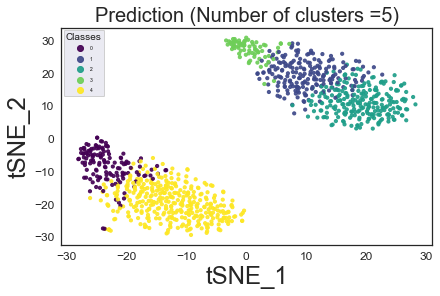

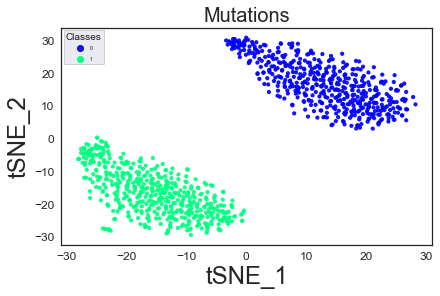


number of cells Wild =  511
number of Mutation cells  =  496
For label 0:
number of cells of the cluster: 136
Percentage of occurrences of wild cells: 0.00%
Percentage of occurrences of mutation cells: 100.00%
For label 1:
number of cells of the cluster: 201
Percentage of occurrences of wild cells: 100.00%
Percentage of occurrences of mutation cells: 0.00%
For label 2:
number of cells of the cluster: 236
Percentage of occurrences of wild cells: 100.00%
Percentage of occurrences of mutation cells: 0.00%
For label 3:
number of cells of the cluster: 74
Percentage of occurrences of wild cells: 100.00%
Percentage of occurrences of mutation cells: 0.00%
For label 4:
number of cells of the cluster: 360
Percentage of occurrences of wild cells: 0.00%
Percentage of occurrences of mutation cells: 100.00%


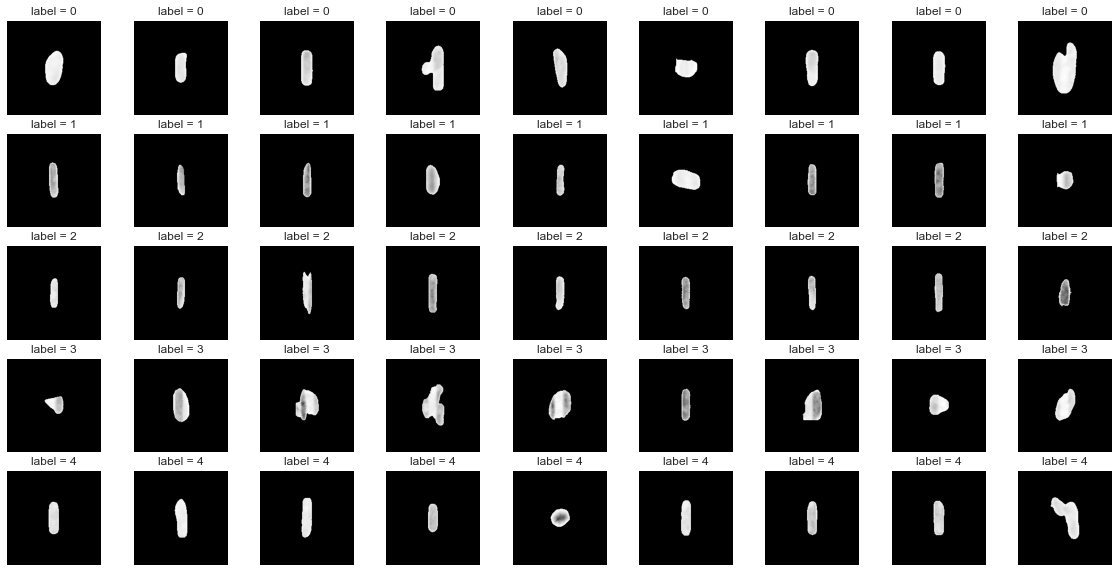

Silhouette: 0.3943, DB: 0.8047, CH: 3273.1644


In [8]:
z_test = autoencoder_cvae.encode(X_test,Y_test)
#z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 5
z_test = z_test.detach().numpy()
#z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_test)
clustering_labels = clustering.predict(z_test)
proj_2d = tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=5,data="cells",cmap=cmap)
pourcentage_cells(clustering_labels,y_test)

# Samples from each cluster
nb_samples = 9
l = list(set(clustering_labels))
fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(20,10))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        axes[label2][sample_index].set_title("label = "+str(label2))
        axes[label2][sample_index].grid(False)
        axes[label2][sample_index].axis('off')
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()

s_16 = silhouette_score(proj_2d, clustering_labels)
db_16 = davies_bouldin_score(proj_2d, clustering_labels)
ch_16 = calinski_harabasz_score(proj_2d, clustering_labels)
print(f"Silhouette: {s_16:.4f}, DB: {db_16:.4f}, CH: {ch_16:.4f}")

**Clustering using GaussianMixture : 9 clusters**

<Figure size 432x288 with 0 Axes>

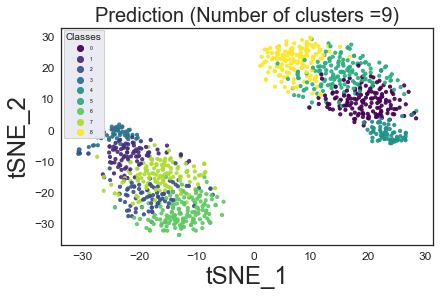

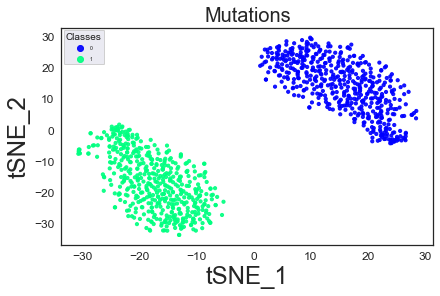


number of cells Wild =  511
number of Mutation cells  =  496
For label 0:
number of cells of the cluster: 150
Percentage of occurrences of wild cells: 100.00%
Percentage of occurrences of mutation cells: 0.00%
For label 1:
number of cells of the cluster: 79
Percentage of occurrences of wild cells: 0.00%
Percentage of occurrences of mutation cells: 100.00%
For label 2:
number of cells of the cluster: 89
Percentage of occurrences of wild cells: 0.00%
Percentage of occurrences of mutation cells: 100.00%
For label 3:
number of cells of the cluster: 52
Percentage of occurrences of wild cells: 0.00%
Percentage of occurrences of mutation cells: 100.00%
For label 4:
number of cells of the cluster: 65
Percentage of occurrences of wild cells: 100.00%
Percentage of occurrences of mutation cells: 0.00%
For label 5:
number of cells of the cluster: 153
Percentage of occurrences of wild cells: 100.00%
Percentage of occurrences of mutation cells: 0.00%
For label 6:
number of cells of the cluster: 147

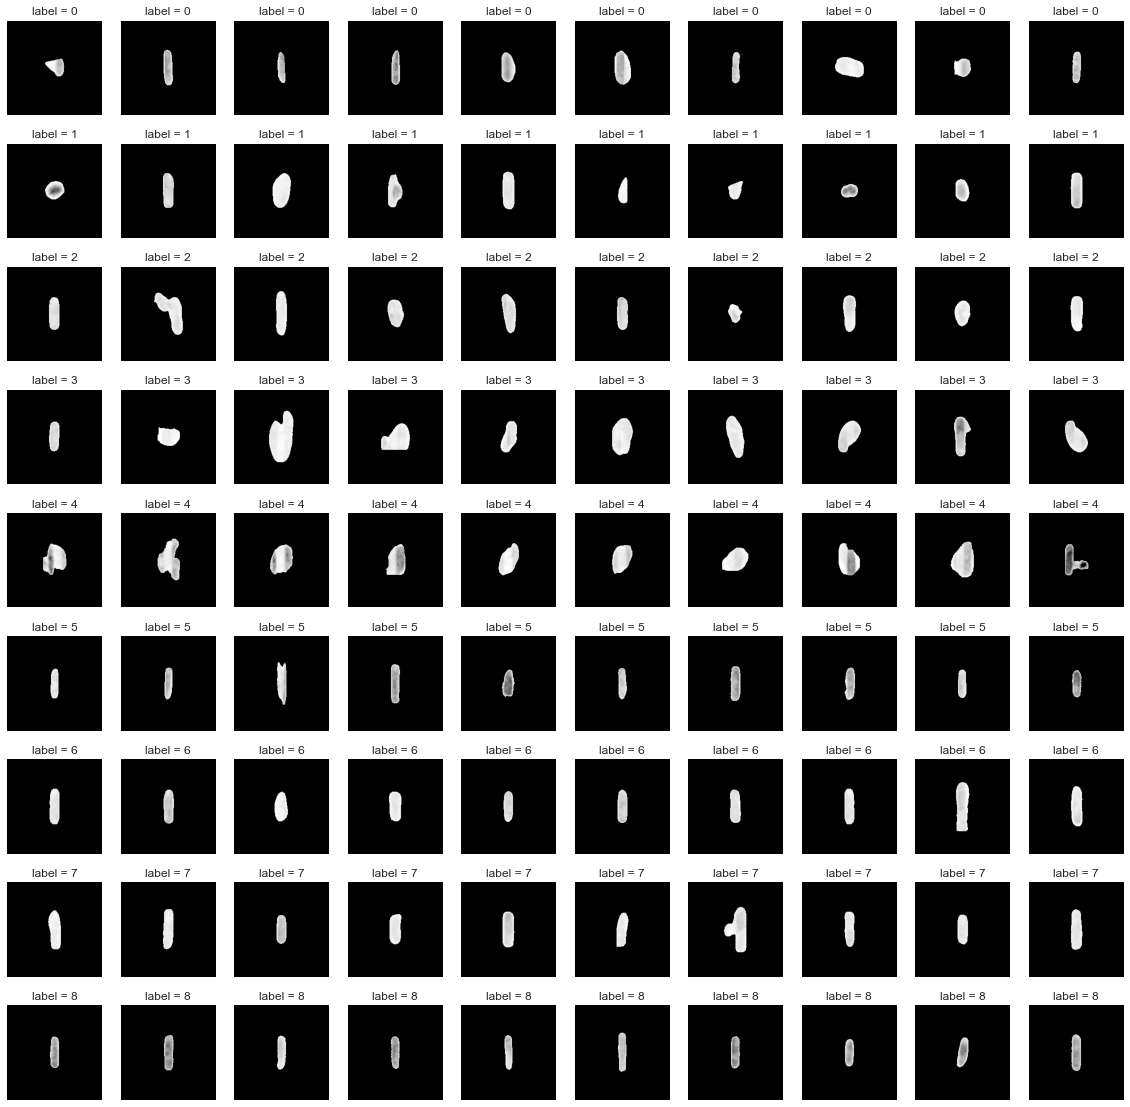

Silhouette: 0.2468, DB: 1.2235, CH: 2474.3344


In [9]:
z_test = autoencoder_cvae.encode(X_test,Y_test)
#z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 9
z_test = z_test.detach().numpy()
#z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_test)
clustering_labels = clustering.predict(z_test)
proj_2d = tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=9,data="cells")
pourcentage_cells(clustering_labels,y_test)

# Samples from each cluster
nb_samples = 10
l = list(set(clustering_labels))
fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(20,20))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        axes[label2][sample_index].set_title("label = "+str(label2))
        axes[label2][sample_index].grid(False)
        axes[label2][sample_index].axis('off')
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()

s_16 = silhouette_score(proj_2d, clustering_labels)
db_16 = davies_bouldin_score(proj_2d, clustering_labels)
ch_16 = calinski_harabasz_score(proj_2d, clustering_labels)
print(f"Silhouette: {s_16:.4f}, DB: {db_16:.4f}, CH: {ch_16:.4f}")